#  Intel Image Classification. 
## Image Scene Classification of Multiclass. 

## Modeling with MobileNet

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Image preprocessing

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [3]:
train_path = 'Dataset - Large\seg_train'
valid_path = 'Dataset - Large\seg_test'
test_path = 'Dataset - Large\seg_pred'

#### Data Augmentation

In [4]:
traindatagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_batches=traindatagen.flow_from_directory(directory=train_path, target_size=(224,224), batch_size=128)

Found 14034 images belonging to 6 classes.


In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_batches = valid_datagen.flow_from_directory(directory=valid_path,shuffle = True, target_size=(224,224), batch_size=128)

Found 3000 images belonging to 6 classes.


In [66]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_batches = test_datagen.flow_from_directory(directory=test_path,shuffle = True, target_size=(224,224), batch_size=128)


Found 84 images belonging to 1 classes.


**Observations:**
1. Overfitting is observed in modelling.
2. Data Augmentaion is done to reduce overfitting.
3. The images are reshaped to 224 * 224.
4. Data Augmentation that is done to train set should not be repeated to validation and test set
5. Rescaling should be done to validation and test set as well
6. Test batches are not shuffled. This will help in predicting class for each image in test set

In [7]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

## Finetuning the model

In [8]:
x = mobile.layers[-6].output
output = Dense(units=6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [9]:
for layer in model.layers[:-20]:
    layer.trainable = False

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

**Observations:**
1. All the layers except last 6 are grabbed
2. A dense layer is added as last layer
2. This last layer  is softmax and contain 6 units, because we have 6 classes of images

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
filepath="weights_mobileNet_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',save_weights_only=False,verbose=0,  save_best_only=True, mode='max')

## Training the model

In [12]:
model.fit(x=train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches), epochs=13,verbose=1,callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 110 steps, validate for 24 steps
Epoch 1/13
110/110 [==============================] - 1114s 10s/step - loss: 0.5366 - accuracy: 0.8114 - val_loss: 1.0306 - val_accuracy: 0.7180
Epoch 2/13
110/110 [==============================] - 1228s 11s/step - loss: 0.3034 - accuracy: 0.8906 - val_loss: 0.4824 - val_accuracy: 0.8247
Epoch 3/13
110/110 [==============================] - 1283s 12s/step - loss: 0.2674 - accuracy: 0.9060 - val_loss: 0.2992 - val_accuracy: 0.8903
Epoch 4/13
110/110 [==============================] - 1367s 12s/step - loss: 0.2340 - accuracy: 0.9168 - val_loss: 0.2802 - val_accuracy: 0.9040
Epoch 5/13
110/110 [==============================] - 1360s 12s/step - loss: 0.2164 - accuracy: 0.9232 - val_loss: 0.2537 - val_accuracy: 0.9080
Epoch 6/13
110/110 [==============================] - 1531s 14s/step - loss: 0.1979 - accuracy: 0.9270 - val_loss: 0.2891 - val_accuracy: 0.8943
Epoch 7/13
110/110 [=================

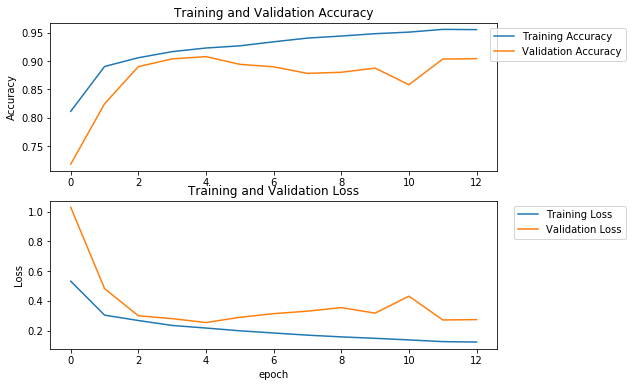

In [15]:
import matplotlib.pyplot as plt

acc      = model.history.history['accuracy']
val_acc  = model.history.history['val_accuracy']
loss     = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Observations:**
1. In the first few iterations the loss/accuracy changes a lot.
2. There is some overfitting found in the results.

## Plotting confusion matrix

In [79]:
model.save('mobileNetModel.h5')

In [80]:
new_model = tf.keras.models.load_model('mobileNetModel.h5')

In [81]:
predictionsV = new_model.predict(x=valid_batches, steps=len(valid_batches), verbose=0)

In [82]:
scores = new_model.evaluate(valid_batches, verbose=0)
print("%s: %.2f%%" % (new_model.metrics_names[1], scores[1]*100))

  ...
    to  
  ['...']
accuracy: 90.43%


**Observations:**
1. After training, the model is saved to an h5 file.
2. The validation accuracy is 90.43%

In [83]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=predictionsV.argmax(axis=1))

In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 57  71  91  77  71  70]
 [ 75  64 114  79  62  80]
 [ 70  87 111 104  92  89]
 [ 73  78  98  95  85  96]
 [ 59  92 100  72  96  91]
 [ 73  85  95  72  68 108]]


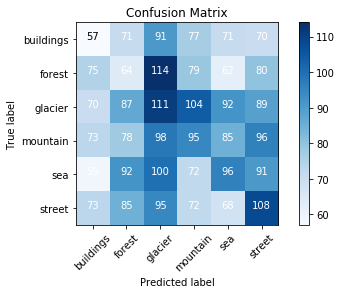

In [85]:
cm_plot_labels = ['buildings','forest','glacier','mountain','sea','street']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Observations:**
1. The confusion matrix show performance of all classes.
2. Many images are predicted as glacier even if they belong to other classes.
3. The confusion do not show a very good performance of model.

## Prediction on test images

In [68]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [77]:
test_batches.filenames[:5]

['unknown\\101.jpg',
 'unknown\\103.jpg',
 'unknown\\11.jpg',
 'unknown\\110.jpg',
 'unknown\\117.jpg']

In [71]:
preds_cls_idx = predictions.argmax(axis=-1)

array([2, 3, 2, 0, 4, 3, 3, 5, 1, 3, 2, 1, 3, 3, 5, 2, 0, 2, 2, 1, 0, 5,
       4, 4, 4, 3, 4, 2, 4, 5, 4, 2, 2, 0, 1, 3, 4, 5, 5, 3, 2, 5, 3, 5,
       2, 0, 2, 4, 1, 0, 0, 0, 2, 5, 2, 0, 3, 3, 1, 1, 5, 0, 0, 2, 5, 0,
       1, 5, 5, 4, 3, 2, 0, 1, 4, 5, 5, 2, 3, 1, 4, 4, 2, 2], dtype=int64)

In [73]:
# https://stackoverflow.com/questions/57516673/how-to-perform-prediction-using-predict-generator-on-unlabeled-test-data-in-kera
import numpy as np
idx_to_cls = {v: k for k, v in train_batches.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_batches.filenames, preds_cls))

In [76]:
train_batches.class_indices.items()

dict_items([('buildings', 0), ('forest', 1), ('glacier', 2), ('mountain', 3), ('sea', 4), ('street', 5)])

In [78]:
filenames_to_cls[:5]

[('unknown\\101.jpg', 'glacier'),
 ('unknown\\103.jpg', 'mountain'),
 ('unknown\\11.jpg', 'glacier'),
 ('unknown\\110.jpg', 'buildings'),
 ('unknown\\117.jpg', 'sea')]

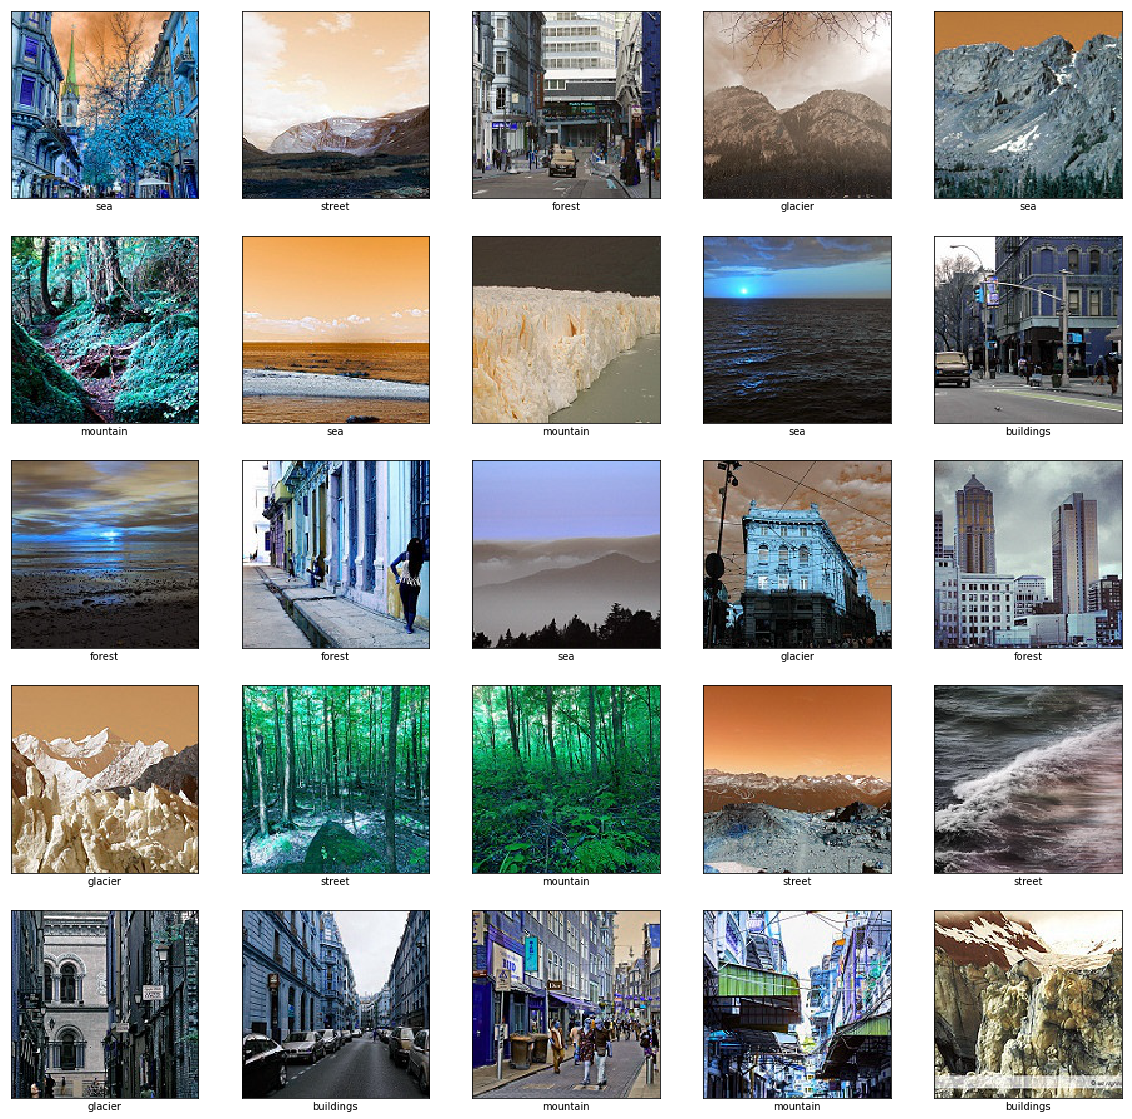

In [63]:
import cv2 as cv
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv.imread(r'Dataset - Large\\seg_pred\\'+filenames_to_cls[i][0])
    plt.imshow(img)
    plt.xlabel(filenames_to_cls[i][1])
plt.show()


**Observations:**
1. The class labels for test images is not given. Hence we cant calculate its accuracy.
2. Though the accuracy on validation set is fairly good, the results on test batches are not  good.
3. The classes in this dataset are very similar to classes in imagenet dataset, but still mobileNet model has failed to give good performance on test set